# A Guide to Time Series Visualization with Python 3
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3

In [72]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

## Load Data

In [41]:
data = sm.datasets.co2.load_pandas()
co2 = data.data

In [42]:
print(co2.shape)
co2.head()

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [43]:
co2.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


## indexing with time series data

In [44]:
co2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

el index ya es un datetime, hay 2284 datos semanales registrados.

para el ejemplo, propone que esa granulometría es alta, y propone hacer un resample mensual.

In [45]:
y = co2['co2'].resample('MS').mean()
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

Es muy facil hacer subsets del dataset:

In [46]:
y["1990":] # valores posteriores a 1990

1990-01-01    353.650
1990-02-01    354.650
1990-03-01    355.480
1990-04-01    356.175
1990-05-01    357.075
               ...   
2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, Length: 144, dtype: float64

In [47]:
y["1995-01-01":"1996-01-01"] # valores entre 1995 y 1996

1995-01-01    359.975
1995-02-01    360.925
1995-03-01    361.575
1995-04-01    363.360
1995-05-01    363.700
1995-06-01    363.250
1995-07-01    361.800
1995-08-01    359.375
1995-09-01    358.000
1995-10-01    357.850
1995-11-01    359.475
1995-12-01    360.700
1996-01-01    362.025
Freq: MS, Name: co2, dtype: float64

## missing values

In [48]:
print(y.isnull().sum())

5


hay 5 valores nulos. los relleno con una interpolacion lineal

In [49]:
y.interpolate(inplace=True)
print(y.isnull().sum())

0


## Visualizacion

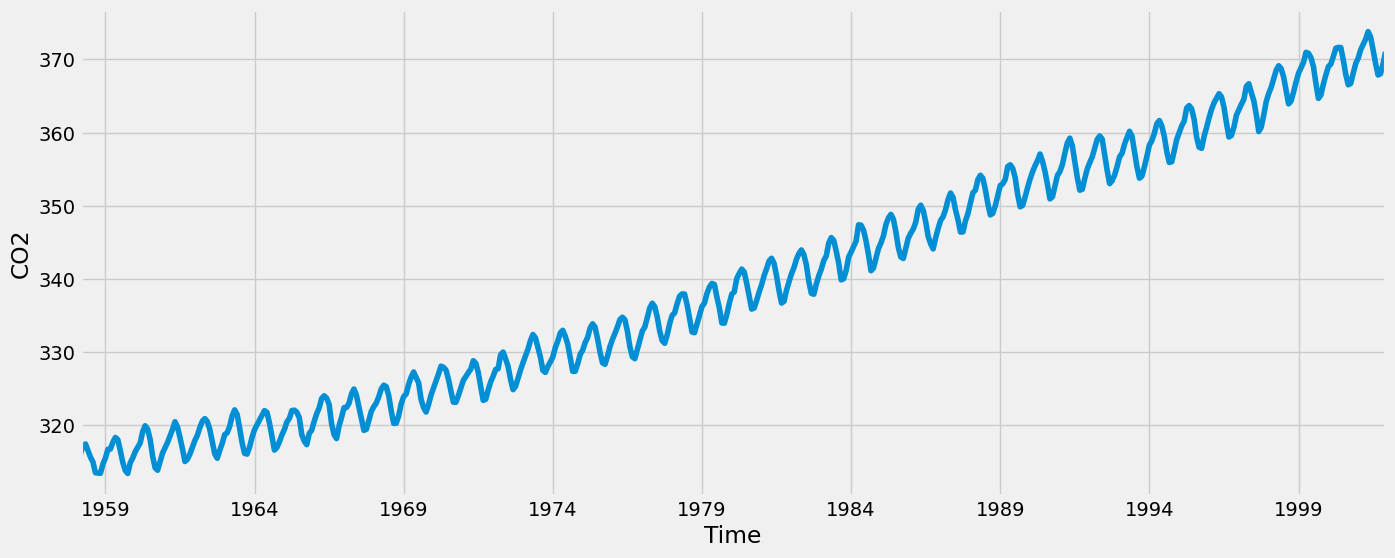

In [50]:
y.plot(xlabel="Time", ylabel="CO2", figsize=(15, 6))
plt.show()

### SEASONAL DECOMPOSITION 
Fortunately, statsmodels provides the convenient seasonal_decompose function to perform seasonal decomposition out of the box. If you are interested in learning more, the reference for its original implementation can be found in the following paper, “STL: A Seasonal-Trend Decomposition Procedure Based on Loess.” http://www.wessa.net/download/stl.pdf

C:\Users\afernandez\AppData\Local\Temp\ipykernel_9168\2968329277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


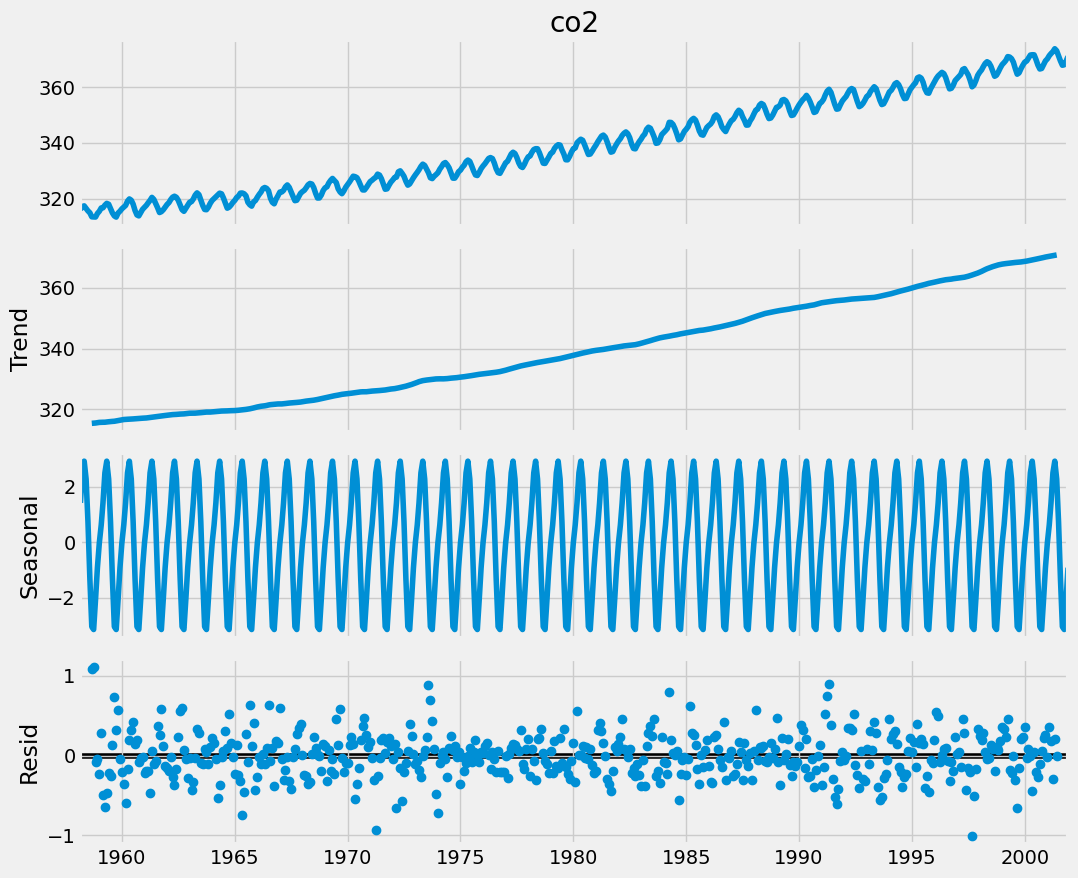

In [51]:
# By default, seasonal_decompose returns a figure of relatively small size, 
# so the first two lines of this code chunk ensure that the output figure is large 
# enough for us to visualize.
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(y, model = "additive")
fig = decomposition.plot()
fig.show()

## Parameter Selection for the ARIMA Time Series Model
When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest.


We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. 

In [82]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Parameters that will be tested in the search space: ", len(pdq) * len(seasonal_pdq))
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Parameters that will be tested in the search space:  64
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [62]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

results_list = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            results_list.append({
                'param': param,
                'param_seasonal': param_seasonal,
                'aic': results.aic
            })
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# Ordenar los resultados por AIC
sorted_results = sorted(results_list, key=lambda x: x['aic'])

# Imprimir todos los resultados ordenados
print("\nTodos los modelos ordenados por AIC:")
for result in sorted_results:
    print('ARIMA{}x{}12 - AIC:{}'.format(result['param'], result['param_seasonal'], result['aic']))

# Imprimir el mejor modelo (menor AIC)
best_model = sorted_results[0]
print("\nMejor modelo:")
print('ARIMA{}x{}12 - AIC:{}'.format(best_model['param'], best_model['param_seasonal'], best_model['aic']))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.566911498647
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.311045985636
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:6027.308062146467
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1846.0523019080354
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1564.0164036599035
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1447.0123313257536
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1355.1071785709705
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1008.7196541877036
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:970.0791640511542
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1020.9958522037775
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1020.8428199683458
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:994.7672431368505
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1309.5787140286075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1001.8351313684991
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:965.2868391026157
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1200.8879303288334
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1005.300004264734
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:971.8475839643808


## Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We’ll start by plugging the optimal parameter values into a new SARIMAX model:

In [74]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 2),
                                seasonal_order=(1, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9870      0.006    157.650      0.000       0.975       0.999
ma.L1         -0.3473      0.043     -8.039      0.000      -0.432      -0.263
ma.L2         -0.0451      0.047     -0.952      0.341      -0.138       0.048
ar.S.L12       1.0043      0.000   4526.537      0.000       1.004       1.005
ma.S.L12      -0.8471      0.046    -18.579      0.000      -0.936      -0.758
ma.S.L24      -0.0741      0.045     -1.642      0.101      -0.162       0.014
sigma2         0.0808      0.005     15.653      0.000       0.071       0.091


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

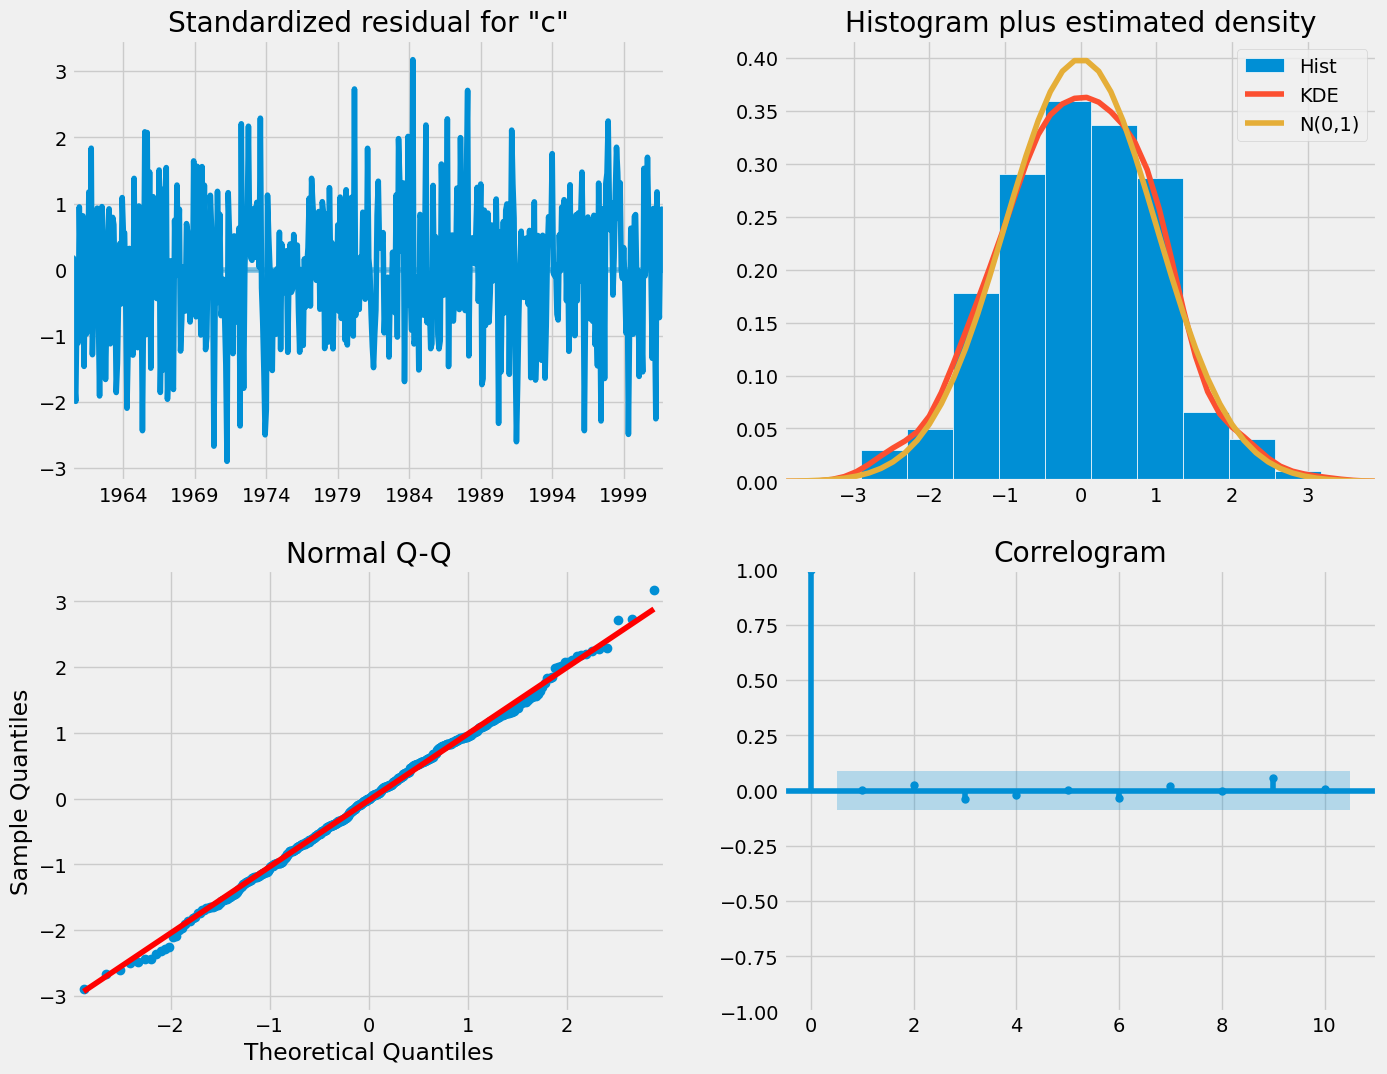

In [75]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [76]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at January 1998.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the CO2 time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

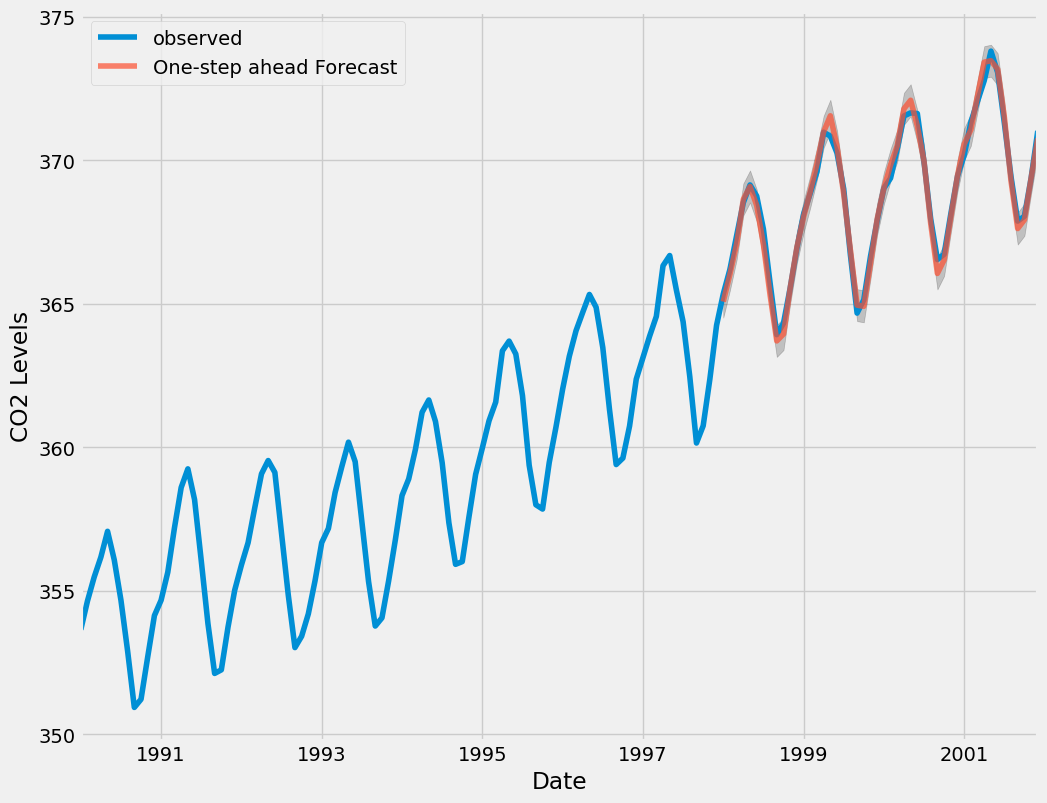

In [77]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [78]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))




The Mean Squared Error of our forecasts is 0.08


In [83]:
def calculate_forecast_errors(y_true, y_pred):
    """
    Calcula varias métricas de error para forecasting.
   
    :param y_true: Array de valores reales
    :param y_pred: Array de valores predichos
    :return: Diccionario con las métricas de error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
   
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)
    # MSE (Mean Squared Error)
    mse = ((y_pred - y_true) ** 2).mean()
    # RMSE (Root Mean Squared Error)
    rmse = root_mean_squared_error(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # MDAPE (Median Absolute Percentage Error)
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    # SMAPE (Symmetric Mean Absolute Percentage Error)
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
 
    return {
        'MAE\t :': mae,
        'MSE\t :': mse,
        'RMSE\t :': rmse,
        'MAPE  [%]:': mape,
        'MDAPE [%]:': mdape,
        'SMAPE [%]:': smape
    }
 
# Función para imprimir los resultados de manera formateada
def print_forecast_errors(errors):
    for metric, value in errors.items():
        print(f"{metric} {value:.4f}")


errors = calculate_forecast_errors(y_forecasted, y_truth)
print_forecast_errors(errors)

MAE	 : 0.2270
MSE	 : 0.0792
RMSE	 : 0.2815
MAPE  [%]: 0.0615
MDAPE [%]: 0.0579
SMAPE [%]: 0.0615


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [84]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

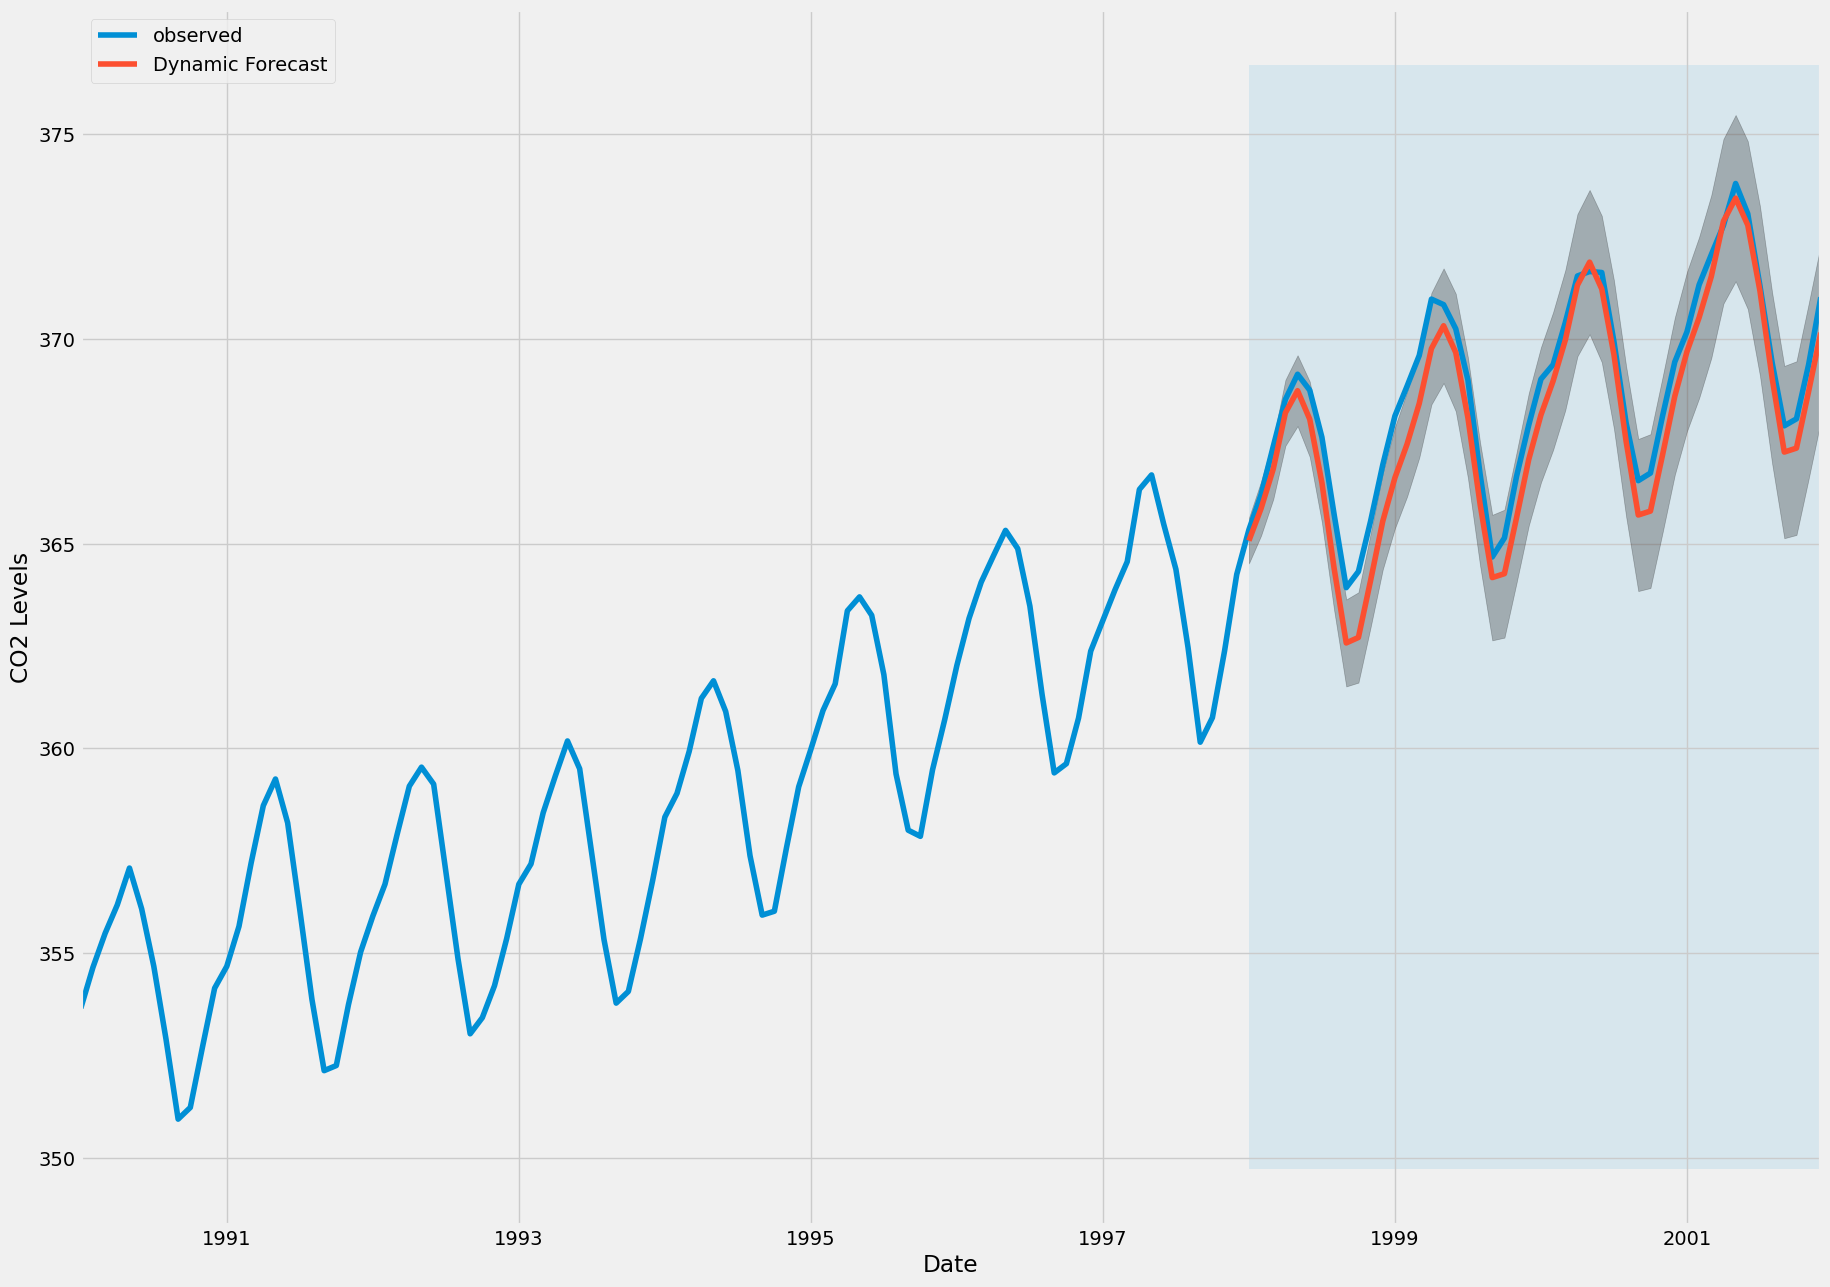

In [85]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [86]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.69


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

## Producing and Visualizing Forecasts
In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [87]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

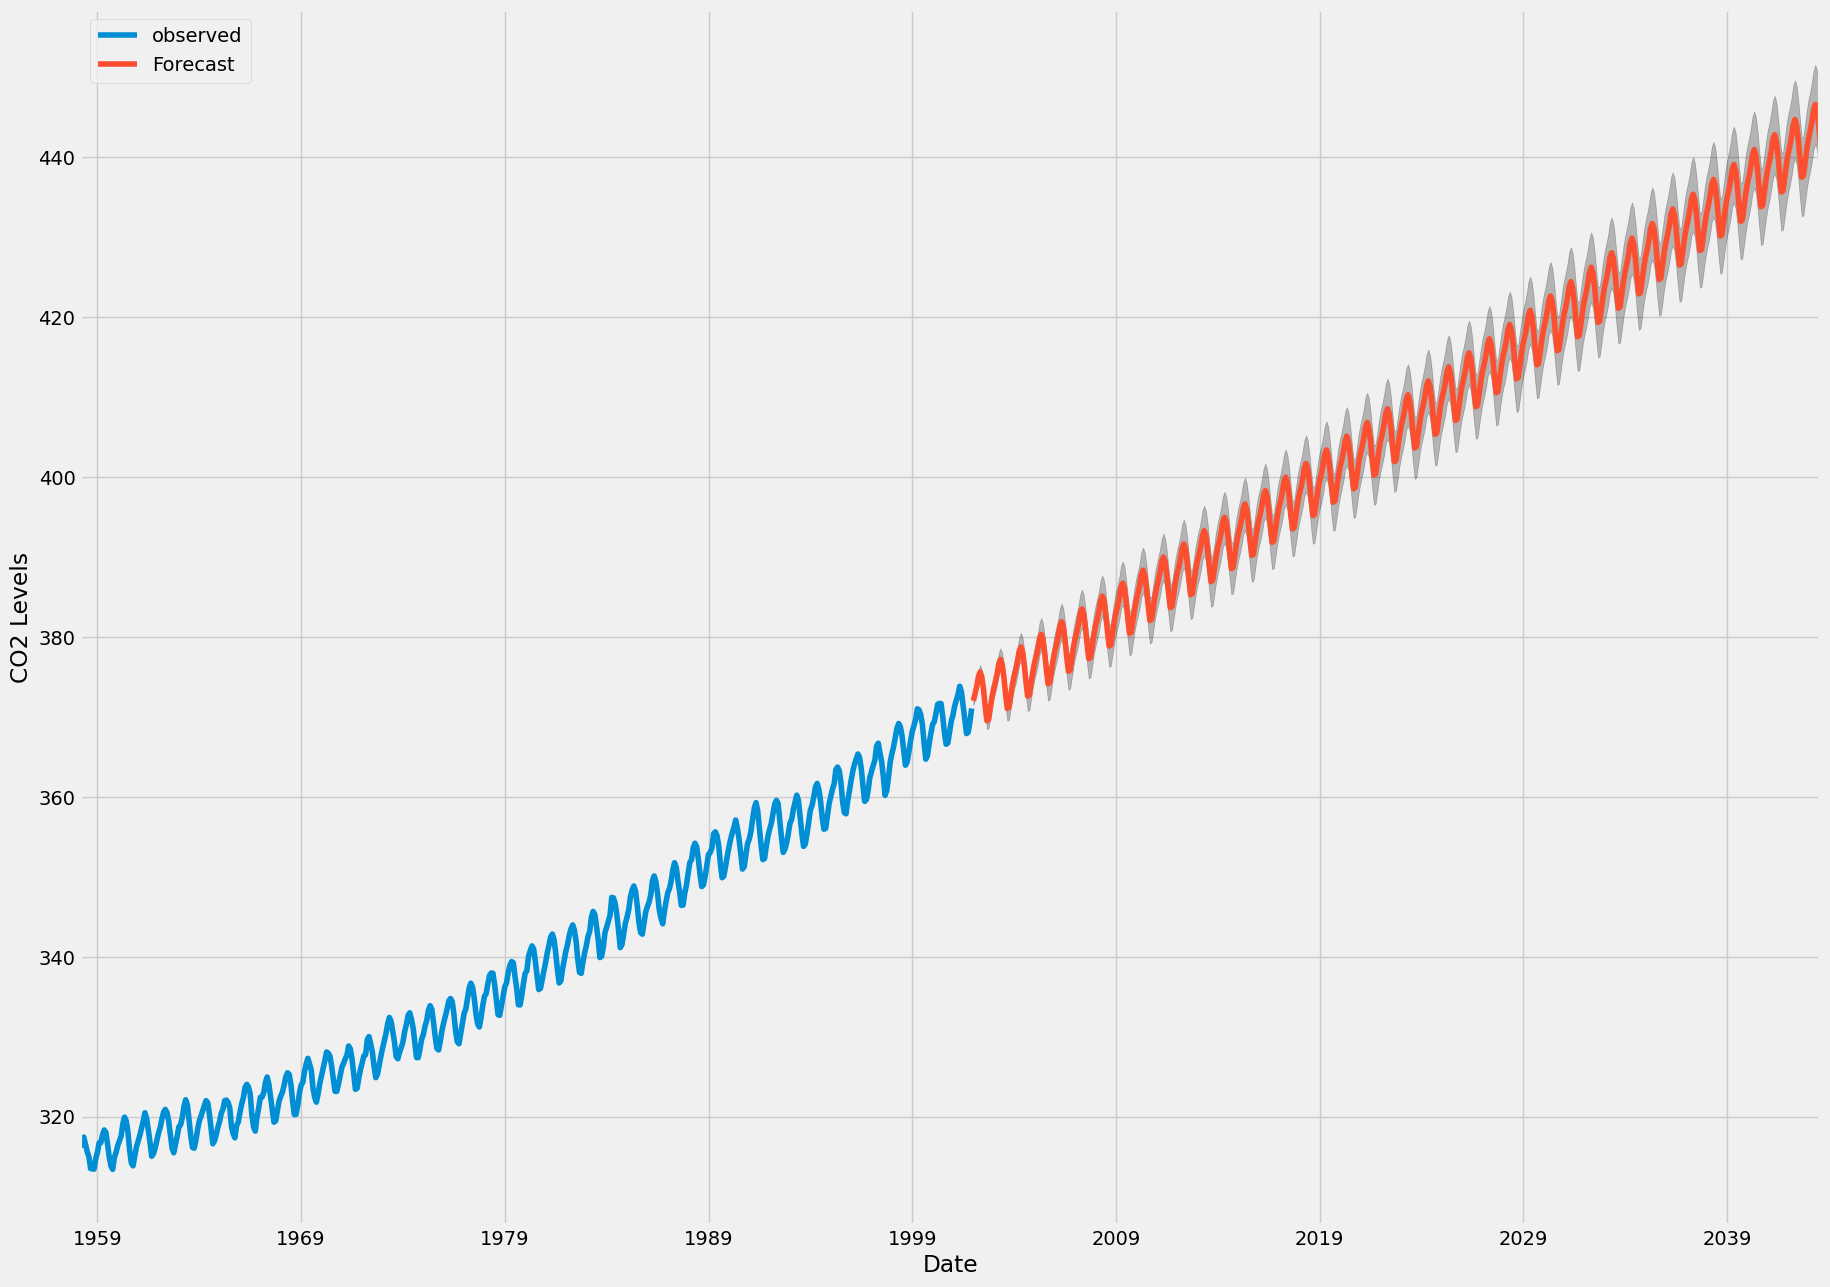

In [88]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Conclusion

In this tutorial, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series.

Here are a few other things you could try:

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.